<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/Video-Based-Projects/blob/main/GroundingDINO-SAM-DeAOT/Det_Seg_Track_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/z-x-yang/Segment-and-Track-Anything.git

Cloning into 'Segment-and-Track-Anything'...
remote: Enumerating objects: 656, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 656 (delta 161), reused 141 (delta 141), pack-reused 463
Receiving objects: 100% (656/656), 230.30 MiB | 39.96 MiB/s, done.
Resolving deltas: 100% (310/310), done.


In [3]:
%cd Segment-and-Track-Anything/

/content/Segment-and-Track-Anything


In [2]:
!sh script/install.sh

/content/Segment-and-Track-Anything
Obtaining file:///content/Segment-and-Track-Anything/sam
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment-anything
/content/Segment-and-Track-Anything
Obtaining GroundingDINO from git+https://github.com/IDEA-Research/GroundingDINO.git@main#egg=GroundingDINO
  Cloning https://github.com/IDEA-Research/GroundingDINO.git (to revision main) to ./src/groundingdino
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /content/Segment-and-Track-Anything/src/groundingdino
  Resolved https://github.com/IDEA-Research/GroundingDINO.git to commit 2b62f419c292ca9c518daae55512fabc3fead4a4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 10.1 MB/s eta 0:00:00
  Running setup.

In [3]:
!sh script/download_ckpt.sh

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Error:

	[Errno 2] No such file or directory: './ckpt'

To report issues, please visit https://github.com/wkentaro/gdown/issues.
--2024-01-30 07:15:56--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.74, 18.173.166.31, 18.173.166.48, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘./ckpt/sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   141MB/s    in 2.5s    

2024-01-30 07:15:59 (141 MB/s) - ‘./ckpt/sam_vit_b_01ec64.pth’ saved [375042383/375042383]

--2024-01-30 07:15:59--  https://huggingface.co

In [4]:
!cp -rf "../drive/MyDrive/Sources/Individual Clips/TechnicalSampleForTest00094867.mov" "./assets/"

In [4]:
!pwd

/content/Segment-and-Track-Anything


In [5]:
import sys
sys.path.insert(0,'/content/Segment-and-Track-Anything')

In [6]:
sys.path.insert(0,'/content/Segment-and-Track-Anything/src/groundingdino')

In [ ]:
from src.groundingdino.groundingdino.models import build_model

/content/Segment-and-Track-Anything/src/groundingdino/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [ ]:
from SegTracker import SegTracker

/content/Segment-and-Track-Anything/src/groundingdino/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [7]:
import os
import cv2
from SegTracker import SegTracker
from model_args import aot_args,sam_args,segtracker_args
from PIL import Image
from aot_tracker import _palette
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import gc
def save_prediction(pred_mask,output_dir,file_name):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask.save(os.path.join(output_dir,file_name))
def colorize_mask(pred_mask):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask = save_mask.convert(mode='RGB')
    return np.array(save_mask)
def draw_mask(img, mask, alpha=0.7, id_countour=False):
    img_mask = np.zeros_like(img)
    img_mask = img
    if id_countour:
        # very slow ~ 1s per image
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[obj_ids!=0]

        for id in obj_ids:
            # Overlay color on  binary mask
            if id <= 255:
                color = _palette[id*3:id*3+3]
            else:
                color = [0,0,0]
            foreground = img * (1-alpha) + np.ones_like(img) * alpha * np.array(color)
            binary_mask = (mask == id)

            # Compose image
            img_mask[binary_mask] = foreground[binary_mask]

            countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
            img_mask[countours, :] = 0
    else:
        binary_mask = (mask!=0)
        countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
        foreground = img*(1-alpha)+colorize_mask(mask)*alpha
        img_mask[binary_mask] = foreground[binary_mask]
        img_mask[countours,:] = 0

    return img_mask.astype(img.dtype)

In [22]:
video_name = 'TechnicalSampleForTest00094867'
io_args = {
    'input_video': f'./assets/{video_name}.mov',
    'output_mask_dir': f'./assets/{video_name}_masks', # save pred masks
    'output_video': f'./assets/{video_name}_seg.avi', # mask+frame vizualization, mp4 or avi, else the same as input video
    'output_gif': f'./assets/{video_name}_seg.gif', # mask visualization
}

In [ ]:
!mv "/content/R50_DeAOTL_PRE_YTB_DAV.pth" "./ckpt/R50_DeAOTL_PRE_YTB_DAV.pth"

In [16]:
import pdb

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
SegTracker has been initialized


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


processed frame 0, obj_num 1


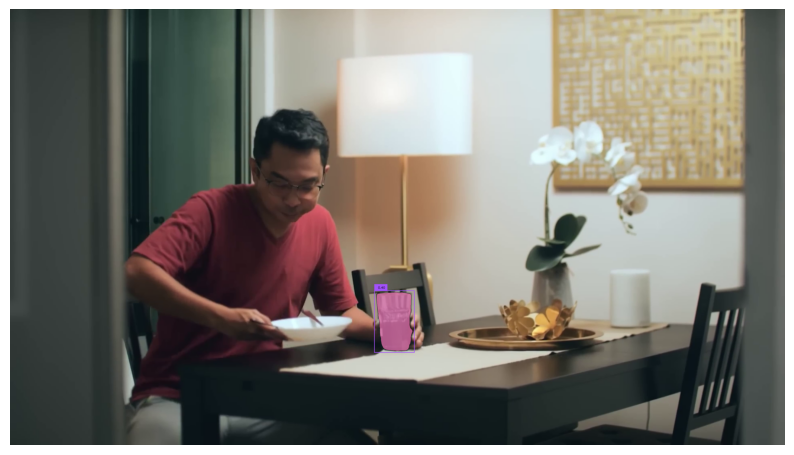

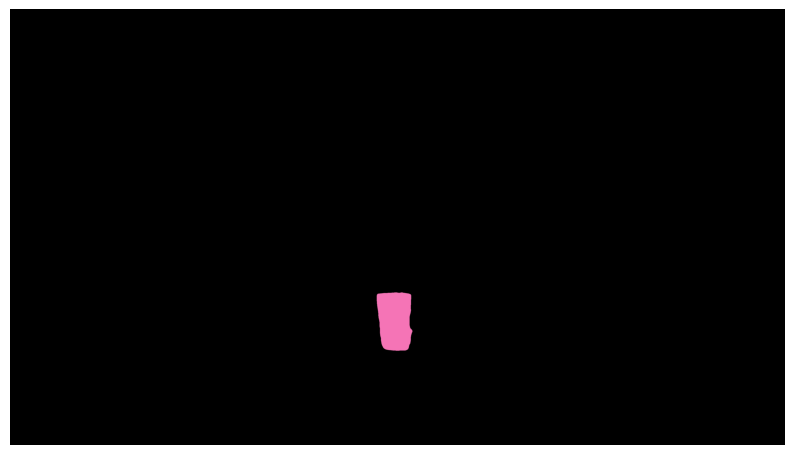

In [9]:
# choose good parameters in sam_args based on the first frame segmentation result
# other arguments can be modified in model_args.py
# note the object number limit is 255 by default, which requires < 10GB GPU memory with amp
sam_args['generator_args'] = {
        'points_per_side': 30,
        'pred_iou_thresh': 0.8,
        'stability_score_thresh': 0.9,
        'crop_n_layers': 1,
        'crop_n_points_downscale_factor': 2,
        'min_mask_region_area': 200,
    }

# Set Text args
'''
parameter:
    grounding_caption: Text prompt to detect objects in key-frames
    box_threshold: threshold for box
    text_threshold: threshold for label(text)
    box_size_threshold: If the size ratio between the box and the frame is larger than the box_size_threshold, the box will be ignored. This is used to filter out large boxes.
    reset_image: reset the image embeddings for SAM
'''
grounding_caption = "TV screen, Cup, Cell-phone screen"
box_threshold, text_threshold, box_size_threshold, reset_image = 0.35, 0.5, 0.5, True

cap = cv2.VideoCapture(io_args['input_video'])
frame_idx = 0
segtracker = SegTracker(segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()
#pdb.set_trace()
with torch.cuda.amp.autocast():
  while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    pred_mask, annotated_frame = segtracker.detect_and_seg(frame, grounding_caption, box_threshold, text_threshold, box_size_threshold)
    torch.cuda.empty_cache()
    obj_ids = np.unique(pred_mask)
    obj_ids = obj_ids[obj_ids!=0]
    print("processed frame {}, obj_num {}".format(frame_idx,len(obj_ids)),end='\n')
    break
  cap.release()
  init_res = draw_mask(annotated_frame, pred_mask,id_countour=False)
  plt.figure(figsize=(10,10))
  plt.axis('off')
  plt.imshow(init_res)
  plt.show()
  plt.figure(figsize=(10,10))
  plt.axis('off')
  plt.imshow(colorize_mask(pred_mask))
  plt.show()

  del segtracker
  torch.cuda.empty_cache()
  gc.collect()

In [10]:
# For every sam_gap frames, we use SAM to find new objects and add them for tracking
# larger sam_gap is faster but may not spot new objects in time
segtracker_args = {
    'sam_gap': 49, # the interval to run sam to segment new objects
    'min_area': 200, # minimal mask area to add a new mask as a new object
    'max_obj_num': 255, # maximal object number to track in a video
    'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80%
}

# source video to segment
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)
# output masks
output_dir = io_args['output_mask_dir']
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
pred_list = []
masked_pred_list = []

torch.cuda.empty_cache()
gc.collect()
sam_gap = segtracker_args['sam_gap']
frame_idx = 0
segtracker = SegTracker(segtracker_args, sam_args, aot_args)
segtracker.restart_tracker()

with torch.cuda.amp.autocast():
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        if frame_idx == 0:
            pred_mask, _ = segtracker.detect_and_seg(frame, grounding_caption, box_threshold, text_threshold, box_size_threshold, reset_image)
            # pred_mask = cv2.imread('./debug/first_frame_mask.png', 0)
            torch.cuda.empty_cache()
            gc.collect()
            segtracker.add_reference(frame, pred_mask)
        elif (frame_idx % sam_gap) == 0:
            seg_mask, _ = segtracker.detect_and_seg(frame, grounding_caption, box_threshold, text_threshold, box_size_threshold, reset_image)
            save_prediction(seg_mask, './debug/seg_result', str(frame_idx)+'.png')
            torch.cuda.empty_cache()
            gc.collect()
            track_mask = segtracker.track(frame)
            save_prediction(track_mask, './debug/aot_result', str(frame_idx)+'.png')
            # find new objects, and update tracker with new objects
            new_obj_mask = segtracker.find_new_objs(track_mask, seg_mask)
            if np.sum(new_obj_mask > 0) >  frame.shape[0] * frame.shape[1] * 0.4:
                new_obj_mask = np.zeros_like(new_obj_mask)
            save_prediction(new_obj_mask,output_dir,str(frame_idx)+'_new.png')
            pred_mask = track_mask + new_obj_mask
            # segtracker.restart_tracker()
            segtracker.add_reference(frame, pred_mask)
        else:
            pred_mask = segtracker.track(frame,update_memory=True)
        torch.cuda.empty_cache()
        gc.collect()

        save_prediction(pred_mask,output_dir,str(frame_idx)+'.png')
        # masked_frame = draw_mask(frame,pred_mask)
        # masked_pred_list.append(masked_frame)
        # plt.imshow(masked_frame)
        # plt.show()

        pred_list.append(pred_mask)

        print("processed frame {}, obj_num {}".format(frame_idx,segtracker.get_obj_num()),end='\r')
        frame_idx += 1
    cap.release()
    print('\nfinished')

final text_encoder_type: bert-base-uncased
Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
SegTracker has been initialized


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


processed frame 245, obj_num 1
finished


In [20]:
!which ffmpeg

/usr/bin/ffmpeg


In [23]:
# draw pred mask on frame and save as a video
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if io_args['input_video'][-3:]=='mp4':
    fourcc =  cv2.VideoWriter_fourcc(*"mp4v")
elif io_args['input_video'][-3:] == 'avi':
    fourcc =  cv2.VideoWriter_fourcc(*"MJPG")
    # fourcc = cv2.VideoWriter_fourcc(*"XVID")
else:
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
out = cv2.VideoWriter(io_args['output_video'], fourcc, fps, (width, height))

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    pred_mask = pred_list[frame_idx]
    masked_frame = draw_mask(frame,pred_mask)
    # masked_frame = masked_pred_list[frame_idx]
    masked_frame = cv2.cvtColor(masked_frame,cv2.COLOR_RGB2BGR)
    out.write(masked_frame)
    print('frame {} writed'.format(frame_idx),end='\r')
    frame_idx += 1
#pdb.set_trace()
out.release()
cap.release()
print("\n{} saved".format(io_args['output_video']))
print('\nfinished')

frame 245 writed
./assets/TechnicalSampleForTest00094867_seg.avi saved

finished


In [24]:
# save colorized masks as a gif
imageio.mimsave(io_args['output_gif'],pred_list,fps=fps)
print("{} saved".format(io_args['output_gif']))

./assets/TechnicalSampleForTest00094867_seg.gif saved


In [25]:
# manually release memory (after cuda out of memory)
del segtracker
torch.cuda.empty_cache()
gc.collect()

53